In [5]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
from scipy import stats

###PART 1

countries = ["All"]

#Dataset for all sex
ida = {'SP.DYN.LE00.IN':'Life expectancy at birth'}
dft = wbdata.get_dataframe(ida, country=countries, convert_date=False)
dft.reset_index(inplace=True)


#Dataset for male
idm = {'SP.DYN.LE00.MA.IN':'Life expectancy at birth'}
dfm = wbdata.get_dataframe(idm, country=countries, convert_date=False)
dfm.reset_index(inplace=True) 


#Dataset for female
idf = {'SP.DYN.LE00.FE.IN':'Life expectancy at birth'}
dff = wbdata.get_dataframe(idf, country=countries, convert_date=False)
dff.reset_index(inplace=True)

#Combined dataset
combined = (dft.merge(dfm, on=['country','date']).merge(dff))
combined.rename(columns={'Life expectancy at birth_x':'Combined_LE','Life expectancy at birth_y':'Combined_MALE','Life expectancy at birth':'Combined_FEMALE'},inplace=True)

#Define time period
period = (combined['date'] >='2000') & (combined['date']<='2019')
combined = combined.loc[period]

#Drop rows with less than 10 values and NAN (10 years of data)
combined.dropna(inplace=True)
combined = combined.groupby("country").filter(lambda x: len(x) >= 10)

#Export the dataframe to a csv
Final = combined.to_csv('DATASET_FINAL.csv')

In [6]:
###PART 2

#Question 1
q1 = combined['country'].unique()
print('The number of country in the dataset : {}'.format(len(q1)))

#Question 2
#First filter the combined dataset by date = 2018
combined_2018 = combined[combined['date']=='2018']

q2 = combined_2018['Combined_LE'].max()
q2_answer = combined[combined['Combined_LE']==q2]
print(q2_answer[['country','Combined_LE']])

#Question 3
q3 = combined_2018['Combined_LE'].min()
q3_answer = combined[combined['Combined_LE']==q3]
print(q3_answer[['country','Combined_LE']])

#Question 4
#First create a new column with the absolute difference
combined_2018['Abs_Diff'] = abs(combined_2018['Combined_MALE'] - combined_2018['Combined_FEMALE'])

q4_1 = combined_2018['Abs_Diff'].max()
q4_1_answer = combined_2018[combined_2018['Abs_Diff']==q4_1]
print(q4_1_answer[['country','Abs_Diff']])
q4_2 = combined_2018['Abs_Diff'].tail(1)
print('The difference for the latest datapoint : {}'.format(q4_2.values))

#Question 5
#Define a function to solve this question

def le_increase(df):
    #First, select (in two variables), the first and latest values 
    first = df.drop_duplicates('country',keep='first').reset_index(drop = True)
    last = df.drop_duplicates('country', keep ='last').reset_index(drop=True)
    
    #Then merge the two dataframes to get the Combined_LE (first and last) in the same dataframe
    increase_combined = first.merge(last['Combined_LE'], left_index=True, right_index=True, suffixes=('_recent','_old'), how='right')
    
    #Then the percentage increase
    increase_percentage = (increase_combined['Combined_LE_recent'] - increase_combined['Combined_LE_old']) / increase_combined['Combined_LE_old'].abs() * 100

    #Then, create a new column with the increase in %
    increase_combined["LE_increase"] = increase_percentage 
    
    #Lastly, find and return the 5 largest increase
    best = increase_combined.nlargest(5, ['LE_increase'])

    return best

le_increase(combined)

The number of country in the dataset : 246
                   country  Combined_LE
8115  Hong Kong SAR, China    84.934146
                       country  Combined_LE
5126  Central African Republic       52.805
                    country  Abs_Diff
14398  Syrian Arab Republic    11.185
The difference for the latest datapoint : [3.097]


,country,date,Combined_LE_recent,Combined_MALE,Combined_FEMALE,Combined_LE_old,LE_increase
244,Zambia,2018,63.510,60.533,66.447,44.000,44.340909
158,Malawi,2018,63.798,60.651,66.937,45.090,41.490353
196,Rwanda,2018,68.700,66.518,70.784,48.649,41.215647
203,Sierra Leone,2018,54.309,53.468,55.106,39.441,37.696813
245,Zimbabwe,2018,61.195,59.501,62.598,44.649,37.057941


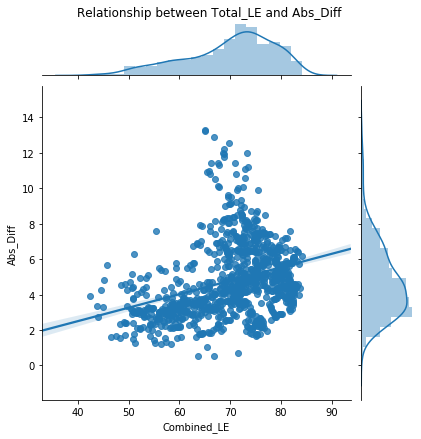

The pearson-r coefficient : 0.31932258073529846
Which indicates a "moderately low" relationship between the two variables


In [7]:
###PART 3

#Question 1

#First create a new column (just like in combined_2018) with the absolute difference in the combined dataframe

combined['Abs_Diff'] = abs(combined['Combined_MALE'] - combined['Combined_FEMALE'])

#Then use a sample of the dataset to improve the visualization (Too many rows ends up making a messy viz). Pandas .sample() method enables me to get randomly generated sample for a given datatset, here I use a "seed" = 10 in order to keep the same data each time I run the program.

combined_sample = combined.sample(1000,random_state=10)
sns.jointplot(x='Combined_LE',y='Abs_Diff',data=combined_sample, kind='reg')
plt.suptitle('Relationship between Total_LE and Abs_Diff',y=1.01)
plt.show()

pearson_r = stats.pearsonr(combined_sample['Combined_LE'],combined_sample['Abs_Diff'])

print('The pearson-r coefficient : {}\nWhich indicates a "moderately low" relationship between the two variables'.format(pearson_r[0]))


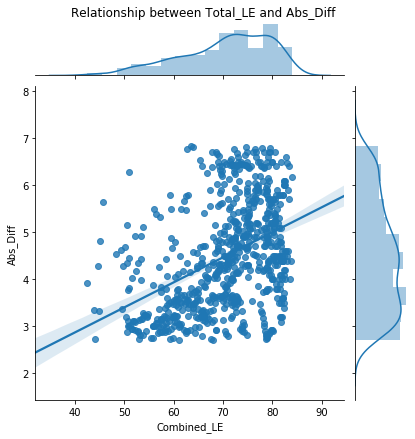

The pearson-r coefficient : 0.4186649830383218
Which indicates a "low medium" relationship between the two variables


In [8]:
#Explanation of the relationship, removing outlier makes the pearson-r coefficient more substantial

#Compute z_score and create a new dataframe (based on combined_sample) with a new column containing the z_score
z_score = abs(stats.zscore(combined_sample['Abs_Diff']))
df = combined_sample
df['z_score'] = z_score

#Create a filter for values (Abs_Diff) within less than 2 standard deviations. Filter the dataset df with low_z
low_z = (z_score<1)
no_outlier = df[low_z]


sns.jointplot(x='Combined_LE',y='Abs_Diff',data=no_outlier, kind='reg')
plt.suptitle('Relationship between Total_LE and Abs_Diff',y=1.01)
plt.show()

pearson_r_n = stats.pearsonr(no_outlier['Combined_LE'],no_outlier['Abs_Diff'])

print('The pearson-r coefficient : {}\nWhich indicates a "low medium" relationship between the two variables'.format(pearson_r_n[0]))


In [6]:
no_outlier

,country,date,Combined_LE,Combined_MALE,Combined_FEMALE,Abs_Diff,z_score
7519,Greece,2004,79.039024,76.600000,81.600000,5.000000,0.108309
1544,Low & middle income,2001,65.660015,63.766556,67.715022,3.948466,0.399719
12570,Qatar,2016,79.868000,78.690000,81.610000,2.920000,0.896601
13062,Senegal,2012,65.448000,63.602000,67.152000,3.550000,0.592229
7018,France,2017,82.575610,79.600000,85.700000,6.100000,0.639751
...,...,...,...,...,...,...,...
10687,"Micronesia, Fed. Sts.",2008,66.099000,64.516000,67.761000,3.245000,0.739584
14588,Thailand,2011,74.593000,71.104000,78.186000,7.082000,1.114184
16057,Zimbabwe,2006,43.853000,42.193000,45.535000,3.342000,0.692720
8064,Honduras,2008,72.803000,70.454000,75.157000,4.703000,0.035181
